# Exemplo de como obter a RNA para emular FK no problema de Shalow Water 2D

In [1]:
# Baixa o código KFS2d_rna (shallow water assimilado por FK e RNA) a partir do repositório espelho do github
!git clone https://github.com/robertopsouto/kfs2d_rna_mirror.git

Cloning into 'kfs2d_rna_mirror'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 171 (delta 80), reused 157 (delta 66), pack-reused 0
Receiving objects: 100% (171/171), 152.75 KiB | 294.00 KiB/s, done.
Resolving deltas: 100% (80/80), done.


In [2]:
# Entra no diretório principal do código de shalow water
%cd kfs2d_rna_mirror

/home/rpsouto/projetos/g-assimila/gitlab/g-assimila/shallow-water/kfs2d_rna_jupyter/kfs2d_rna_mirror

In [3]:
# Compilando o código
!make

gfortran -O2 -c -g ./src/kfsFunctions.f90
gfortran -O2 -c -g ./src/KFS2d.f90
gfortran -o ./KFS2d kfsFunctions.o KFS2d.o -llapack -lblas -g -fcheck=all -Wall -fbacktrace


In [4]:
# Roda o shell script que chama o executável compilado na célula anterior
# Usa filtro de Kalman para fazer a assimilação de dados a cada 10 passos no tempo.
# O ruído no dado de observação é de 10%
# Uso:
# ./run-KFS2d.sh assimType gridX gridY timeStep freqObsT freqObsX freqObsY percNoise neuronNumber

!./run-KFS2d.sh 1 10 10 200 10 2 2 0.1 10

 ./KFS2d 1 10 10 200 10 2 2 0.1 10
 command_argument_count():            9
 freqObsX: 2     
 freqObsY: 2     
 percNoise: 0.1   
 neuronNumber: 10    
 SALVOU CONDICAO INICIAL - qInitialCondExpA.out
 SALVOU RESULTADO DA INTEGRACAO DO MODELO - qModelExpA.out
 Gerou o ruido que sera adicionado ao modelo - gerando as observacoes 
 SALVOU AS OBSERVACOES -- MODELO + Rand - qObservExpA.out
 Inicializou a freqAssim
 Inicializando as matrizes 1
 Inicializando as matrizes 2
 Inicializando as matrizes 3
 Inicializando as matrizes 4
 Inicializando as matrizes 5
 Inicializando as matrizes 6
 Inicializando as matrizes 7
 Inicializando as matrizes 8
 Inicializando as matrizes 9
 Inicializando as matrizes 10
 Completando as matrizes com valores apropriados
 FK Assimilation cycle - timeStep          10
 Primeira chamada dgemm
 Passou pela equacao 3.60
 Segunda chamada dgemm
 Terceira chamada dgemm
 Invertendo matriz
 Store A in Ainv
 Ainv = A
 call DGETRF
 Quarta chamada dgemm
 Quinta chamada dgemm
 

 Primeira chamada dgemm
 Passou pela equacao 3.60
 Segunda chamada dgemm
 Terceira chamada dgemm
 Invertendo matriz
 Store A in Ainv
 Ainv = A
 call DGETRF
 Quarta chamada dgemm
 Quinta chamada dgemm
 Passou pela equacao 3.61
 Passou pela equacao 3.62
 Passou pela equacao 3.63
 passou pela equacao 3.64
 FK Assimilation time:   0.40669199999999961              190
 FK Assimilation cycle - timeStep         200
 Primeira chamada dgemm
 Passou pela equacao 3.60
 Segunda chamada dgemm
 Terceira chamada dgemm
 Invertendo matriz
 Store A in Ainv
 Ainv = A
 call DGETRF
 Quarta chamada dgemm
 Quinta chamada dgemm
 Passou pela equacao 3.61
 Passou pela equacao 3.62
 Passou pela equacao 3.63
 passou pela equacao 3.64
 FK Assimilation time:   0.38351699999999944              200
 Total Process time:    12.541253000000001     
 FIM
Copiando o resultado da assimilacao por FK e os dados para treinamento da RNA.


In [5]:
# Indo para o diretório com o dados que serão usados para treinar a RNA, por meio do MPCA
%cd output/training/

/home/rpsouto/projetos/g-assimila/gitlab/g-assimila/shallow-water/kfs2d_rna_jupyter/kfs2d_rna_mirror/output/training

## Script `Octave` que normaliza os valores do modelo, da observação e da análise (obtida com a assimilação de dados). São gerados os arquivos de treinamento (`x.txt` e `y.txt`) de validação cruzada (`x_valid.txt` e `y_valid.txt`) e de generalização (`x_gen.txt` e `y_gen.txt`), que serão os dados de entrada para o `MPCA-ANN`.

In [6]:
%--------------------------------------------------------------------------
% programa para normalizar os valores da variavel para usar no treinamento da RNA/MPCA
%--------------------------------------------------------------------------
clear all;
close all; clc;
%-----------------------
%leitura dos dados
%-----------------------
qM = load('qModelExpA.out');
qO = load('qObservExpA.out');
qA = load('qAnalysisExpA.out');

valNormInf=-1.0;
valNormSup=+1.0;

qM_norm=(max(qM)*valNormInf-min(qM)*valNormSup+qM*(valNormSup-valNormInf))/(max(qM)-min(qM));
qO_norm=(max(qO)*valNormInf-min(qO)*valNormSup+qO*(valNormSup-valNormInf))/(max(qO)-min(qO));
qA_norm=(max(qA)*valNormInf-min(qA)*valNormSup+qA*(valNormSup-valNormInf))/(max(qA)-min(qA));

[l,n]=size(qM);
pontos_por_ciclo=25;

parc1 = 10*pontos_por_ciclo; % ciclos para treinamento
parc2 =  2*pontos_por_ciclo; % ciclos para validação cruzada
parc3 =  4*pontos_por_ciclo; % clicos para generelização

train_range=parc1;
valid_init=train_range+1;
valid_end=train_range+parc2;
gen_init=valid_end+1;
gen_end=valid_end+parc3;;

fileID = fopen('x.txt','w');
fprintf(fileID,'      %8.5f',qM_norm(1:train_range));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('x.txt','a');
fprintf(fileID,'      %8.5f',qO_norm(1:train_range));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('y.txt','w');
fprintf(fileID,'      %8.5f',qA_norm(1:train_range));
fprintf(fileID,'\n');
fclose(fileID);

fileID = fopen('x_valid.txt','w');
fprintf(fileID,'      %8.5f',qM_norm(valid_init:valid_end));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('x_valid.txt','a');
fprintf(fileID,'      %8.5f',qO_norm(valid_init:valid_end));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('y_valid.txt','w');
fprintf(fileID,'      %8.5f',qA_norm(valid_init:valid_end));
fprintf(fileID,'\n');
fclose(fileID);

fileID = fopen('x_gen.txt','w');
fprintf(fileID,'      %8.5f',qM_norm(gen_init:gen_end));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('x_gen.txt','a');
fprintf(fileID,'      %8.5f',qO_norm(gen_init:gen_end));
fprintf(fileID,'\n');
fclose(fileID);
fileID = fopen('y_gen.txt','w');
fprintf(fileID,'      %8.5f',qA_norm(gen_init:gen_end));
fprintf(fileID,'\n');
fclose(fileID);


In [7]:
parc1

parc1 = 250


In [8]:
parc2

parc2 = 50


In [9]:
parc3

parc3 = 100


In [10]:
!ls -ltr

total 60
-rw-rw-r-- 1 rpsouto rpsouto   71 abr 26 15:13 README.md
-rw-rw-r-- 1 rpsouto rpsouto 2235 abr 26 15:13 normalizar.m
-rw-rw-r-- 1 rpsouto rpsouto 8001 abr 26 15:13 qAnalysisExpA.out
-rw-rw-r-- 1 rpsouto rpsouto 8001 abr 26 15:13 qObservExpA.out
-rw-rw-r-- 1 rpsouto rpsouto 8001 abr 26 15:13 qModelExpA.out
-rw-rw-r-- 1 rpsouto rpsouto 7002 abr 26 15:15 x.txt
-rw-rw-r-- 1 rpsouto rpsouto 3501 abr 26 15:15 y.txt
-rw-rw-r-- 1 rpsouto rpsouto 1402 abr 26 15:15 x_valid.txt
-rw-rw-r-- 1 rpsouto rpsouto  701 abr 26 15:15 y_valid.txt
-rw-rw-r-- 1 rpsouto rpsouto 2802 abr 26 15:15 x_gen.txt
-rw-rw-r-- 1 rpsouto rpsouto 1401 abr 26 15:15 y_gen.txt


In [11]:
%cd ../../../

/home/rpsouto/projetos/g-assimila/gitlab/g-assimila/shallow-water/kfs2d_rna_jupyter

In [12]:
# Baixa o código do mpac-ann do repositório github
!git clone https://github.com/scsr-inpe/mpca-ann.git

Cloning into 'mpca-ann'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 320 (delta 58), reused 79 (delta 23), pack-reused 182
Receiving objects: 100% (320/320), 2.07 MiB | 547.00 KiB/s, done.
Resolving deltas: 100% (118/118), done.


In [13]:
# Entra no diretório principal do código
%cd mpca-ann

/home/rpsouto/projetos/g-assimila/gitlab/g-assimila/shallow-water/kfs2d_rna_jupyter/mpca-ann

In [14]:
# Compila o código 
!make

mpif90 -c -O3 -g src/foul.f90 -o build/foul.o
src/foul.f90:588:0:

                               exponent_string
 
mpif90 -c -O3 -g src/newTypes.f90 -o build/newTypes.o
mpif90 -c -O3 -g src/uniformR8.f90 -o build/uniformR8.o
mpif90 -c -O3 -g src/normalR8.f90 -o build/normalR8.o
mpif90 -c -O3 -g src/annTraining.f90 -o build/annTraining.o
mpif90 -c -O3 -g src/mpcaFunctions.f90 -o build/mpcaFunctions.o
mpif90 -c -O3 -g src/mpca.f90 -o build/mpca.o
mpif90 -c -O3 -g src/annActivation.f90 -o build/annActivation.o
mpif90 -c -O3 -g src/annGeneralization.f90 -o build/annGeneralization.o
mpif90 -c -O3 -g src/main_generalization.f90 -o build/main_generalization.o
mpif90 -c -O3 -g src/main_activation.f90 -o build/main_activation.o
mpif90 -O3 -g -o annMPCA build/foul.o build/uniformR8.o build/newTypes.o build/normalR8.o build/annTraining.o build/mpcaFunctions.o build/mpca.o
mpif90 -O3 -g -o annMLP build/foul.o build/newTypes.o build/annGeneralization.o build/main_generalization.o
mpif90 -O3 -g -o 

In [15]:
# Copia os arquivos de treinamento, de validação cruzada e de generalização gerados anteriormente no k, para o diretório 'data' do mpca-ann
!cp ../kfs2d_rna_mirror/output/training/*.txt data/

In [16]:
# Entra no diretório config, para editar os arquivos de configuração do mpca-ann
%cd config/

/home/rpsouto/projetos/g-assimila/gitlab/g-assimila/shallow-water/kfs2d_rna_jupyter/mpca-ann/config

In [17]:
# Edita o arquivo original configuration.ini tal que:
#    NCLASSES seja igual ao número de pontos de treinamento em x.txt e y.txt (dado pela variável parc1) 
#    NCLASSESVALIDATION seja igual ao número de pontos de validação em x_valid.txt e y_valid.txt (dado pela variável parc2)
#    UPPER_HIDDEN_LAYERS=1 seja igual a LOW_HIDDEN_LAYERS=1, para forçar que a arquitetura da rede tenha somente uma camada
#    LOWER_FIRST_HIDDEN_LAYER=UPPER_FIRST_HIDDEN_LAYER=10, para forçar que esta camana tenha exatamente 10 neurônios
#    LOWER_ACTIVATION_FUNCTION=UPPER_ACTIVATION_FUNCTION=2, para forçar que se use com função de ativação a tangente hiperbólica

!sed -i -e 's/NCLASSES=2000/NCLASSES=250/g' \
        -e 's/NCLASSESVALIDATION=600/NCLASSESVALIDATION=50/g' \
        -e 's/UPPER_HIDDEN_LAYERS=2/UPPER_HIDDEN_LAYERS=1/g' \
        -e 's/LOWER_FIRST_HIDDEN_LAYER=5/LOWER_FIRST_HIDDEN_LAYER=10/g' \
        -e 's/UPPER_FIRST_HIDDEN_LAYER=25/UPPER_FIRST_HIDDEN_LAYER=10/g' \
        -e 's/LOWER_ACTIVATION_FUNCTION=1/LOWER_ACTIVATION_FUNCTION=2/g' \
        -e 's/UPPER_ACTIVATION_FUNCTION=3/UPPER_ACTIVATION_FUNCTION=2/g' \
        configuration.ini

In [19]:
# Edita o arquivo original annConfig.ini, 
# para que o número de classes seja igual ao número de pontos generalização em x_gen.txt e y_gen.txt

!sed -i -e 's/600/100/g' annConfig.in

In [20]:
# Retorna para o diretório do script MPCA-ANN

%cd ..

/home/rpsouto/projetos/g-assimila/gitlab/g-assimila/shallow-water/kfs2d_rna_jupyter/mpca-ann

In [22]:
# Roda e script com 1 Experimento, usando 4 Processos MPI

!./runMPCA 1 4

make: Nothing to be done for 'all'.
           1
************************************************************

                       Experiment   1                       

************************************************************

           2
           1
           1
           1
           2
           2
           2
NFE (total):                 1000 of       1000
Best objective function value: 4.1593 x (10^ -2)
Number of hidden layers:  1
Neurons in hidden layer 1: 10
Activation function:  2
Alpha: 0.5200
Eta: 0.8609
                                                            
                                                            


In [23]:
# Roda esta etapa para obter a solução que possui o menor valor da função objetivo com relação aos dados de generalização

!./annMLP 1 4

           1
           4
         100
           2
           1
           1
          10
           0
           2
 ./output/ann1_1.out
   4.1593320000000003E-002
   4.1518520000000003E-002
 ./output/ann1_2.out
   4.1593320000000003E-002
   4.2894820000000000E-002
 ./output/ann1_3.out
   4.1593320000000003E-002
   4.1624950000000001E-002
 ./output/ann1_4.out
   4.1593320000000003E-002
   4.2049669999999997E-002


In [24]:
# Copia o arquivo ann#.best, relativo ao experimento que obteve no menor erro na etapa de generalização, para o diretório data

!cp output/ann1.best ../kfs2d_rna_mirror/data/ann.best

In [25]:
# Entra no diretório data

%cd ../kfs2d_rna_mirror/data/

/home/rpsouto/projetos/g-assimila/gitlab/g-assimila/shallow-water/kfs2d_rna_jupyter/kfs2d_rna_mirror/data

In [26]:
# Roda o shell script que extrai a informação dos pesos e vies do arquivo ann.best
# São gerados 4 arquivos: wqcsExpA.dat  wqcoExpA.dat  bqcsExpA.dat  bqcoExpA.dat
# Estes 4 arquivos serão lidos pelo kfs2d, para emular o FK por RNA 

!./pesos_vies.sh ann.best

In [27]:
!ls -ltr

total 28
-rw-rw-r-- 1 rpsouto rpsouto  40 abr 26 15:13 README.md
-rwxrwxr-x 1 rpsouto rpsouto 279 abr 26 15:13 pesos_vies.sh
-rw-rw-r-- 1 rpsouto rpsouto 688 abr 26 15:18 ann.best
-rw-rw-r-- 1 rpsouto rpsouto 222 abr 26 15:18 wqcoExpA.dat
-rw-rw-r-- 1 rpsouto rpsouto 120 abr 26 15:18 wqcsExpA.dat
-rw-rw-r-- 1 rpsouto rpsouto  12 abr 26 15:18 bqcsExpA.dat
-rw-rw-r-- 1 rpsouto rpsouto 111 abr 26 15:18 bqcoExpA.dat


In [28]:
%cd ../

/home/rpsouto/projetos/g-assimila/gitlab/g-assimila/shallow-water/kfs2d_rna_jupyter/kfs2d_rna_mirror

In [29]:
# Roda o shell script que chama o executável compilado na célula anterior
# Usa RNA para emular FK na assimilação de dados, a cada 10 passos no tempo.
# Uso:
# ./run-KFS2d.sh assimType gridX gridY timeStep freqObsT freqObsX freqObsY percNoise neuronNumber

!./run-KFS2d.sh 2 10 10 200 10 2 2 0.1 10

 ./KFS2d 2 10 10 200 10 2 2 0.1 10
 command_argument_count():            9
 freqObsX: 2     
 freqObsY: 2     
 percNoise: 0.1   
 neuronNumber: 10    
 SALVOU CONDICAO INICIAL - qInitialCondExpA.out
 SALVOU RESULTADO DA INTEGRACAO DO MODELO - qModelExpA.out
 Gerou o ruido que sera adicionado ao modelo - gerando as observacoes 
 SALVOU AS OBSERVACOES -- MODELO + Rand - qObservExpA.out
 Inicializou a freqAssim
 Inicializando as matrizes 1
 Inicializando as matrizes 2
 Inicializando as matrizes 3
 Inicializando as matrizes 4
 Inicializando as matrizes 5
 Inicializando as matrizes 6
 Inicializando as matrizes 7
 Inicializando as matrizes 8
 Inicializando as matrizes 9
 Inicializando as matrizes 10
 Completando as matrizes com valores apropriados
 Normalizando os dados para RNA
 ANN Assimilation cycle - timeStep          10
 TUDO PRONTO PARA A RNA
 PASSAMOS PELA RNA
 ANN Assimilation time:    9.0430000000000232E-003          10
 ANN Assimilation cycle - timeStep          20
 TUDO PRONTO PA

In [30]:
# Entra no diretório onde o resultado da análise obtido com a assimilação por RNA está salvo

%cd output/full/

/home/rpsouto/projetos/g-assimila/gitlab/g-assimila/shallow-water/kfs2d_rna_jupyter/kfs2d_rna_mirror/output/full

## Script `Octave` que gera figura comparando as curvas do modelo (verdade), da análise obtida por assimilação com filtro de Kalman (FK), e também da análise obtida por assimilação com rede neural emulando filtro de Kalman (RNA).

ans = -9.5540


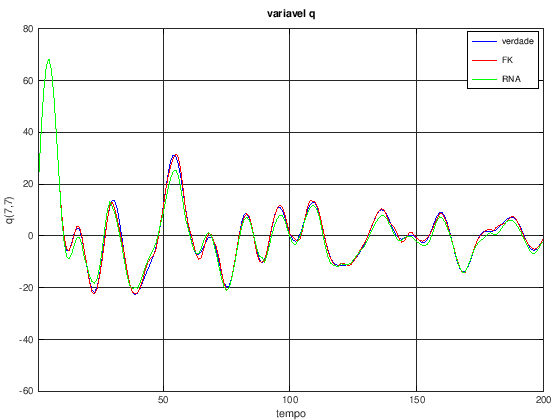

In [31]:
%--------------------------------------------------------------------------
% programa para plotar os graficos
%--------------------------------------------------------------------------
clear all;
close all; clc;
%-----------------------
%leitura dos dados
%-----------------------
qm = load('qModelExpA.out');
qa = load('qAnalysisExpA.out');
% dado da rede
qar = load('qAnalysisExpA_RNA.out');
%
ni = 10;
nj = ni;
nk = 200;
%
ninj = ni*nj;
p = 7; % ponto
%
% dado do modelo
qm3D = reshape(qm,ni,nj,nk);
qpm10 = qm3D(p,p,:);
qpm10v = qpm10(:);
%
%valor estimado pelo Filtro de Kalman
qafk3D = reshape(qa,ni,nj,nk);
qpa10 = qafk3D(p,p,:);
qpa10v = qpa10(:);
%
%estimado pela Rede Neural
 qr3D = reshape(qar,ni,nj,nk);
 qpr10 = qr3D(p,p,:);
 qpr10v = qpr10(:);
%
figure(1)
plot(qpm10v,'b','linewidth',1.5); hold on;
plot(qpa10v,'r','linewidth',1.5);
plot(qpr10v,'g','linewidth',1.5);
title('variavel q'); grid on;
xlabel('tempo');
ylabel('q(7,7)');
legend('verdade','FK','RNA')
axis([1 nk -60 80])
%print -depsc variavelqExpA.eps;
print -dpng -r240 variavelqExpA.png;

In [32]:
!ls -ltr

total 1312
-rw-rw-r-- 1 rpsouto rpsouto     78 abr 26 15:13 README.md
-rw-rw-r-- 1 rpsouto rpsouto   1080 abr 26 15:13 fkFigura.m
-rw-rw-r-- 1 rpsouto rpsouto 320001 abr 26 15:13 qAnalysisExpA.out
-rw-rw-r-- 1 rpsouto rpsouto 320001 abr 26 15:18 qModelExpA.out
-rw-rw-r-- 1 rpsouto rpsouto 320001 abr 26 15:18 qObservExpA.out
-rw-rw-r-- 1 rpsouto rpsouto 320001 abr 26 15:18 qAnalysisExpA_RNA.out
-rw-rw-r-- 1 rpsouto rpsouto  40903 abr 26 15:19 variavelqExpA.png


![Variavel q](kfs2d_rna_mirror/output/full/variavelqExpA.png)